# Clustering embeddings

**Goal**: we want to assign embeddings to a small number of clusters that can be used as tokens for training the sequence model.

### Questions 
- how well does dimensionality reduction retain the signal from the embeddings?
- how does is this clustering method affected by data drift (emergence of new clusters) in comparison to the fibonacci spirals?


In [8]:
from __future__ import annotations
from sklearn.cluster import KMeans, AgglomerativeClustering
import pyarrow
import numpy as np 
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Optional, Union
from sklearn.neighbors import NearestCentroid
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

### Define functions

In [9]:
# will be used with the real data
def sample_ids_from_parquet(
    parquet_path: str | Path, 
    id_column: str = "rinpersoon_id", 
    n: int = 1000, 
    seed: Optional[int] = None
) -> pl.DataFrame:
    """
    Sample n random IDs from a Parquet file and return a DataFrame with all columns
    for those sampled IDs.
    
    Parameters:
    -----------
    parquet_path : str or Path
        Path to the Parquet file
    id_column : str, default="rinpersoon_id"
        Name of the ID column to sample from
    n : int, default=1000
        Number of IDs to sample
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    pl.DataFrame
        DataFrame containing all columns for the sampled IDs
    """
    # Convert to Path object if string is provided
    if isinstance(parquet_path, str):
        parquet_path = Path(parquet_path)

    rng = np.random.default_rng(seed)
    
    # Step 1: Read only the ID column to minimize memory usage
    try:
        ids_df = pl.scan_parquet(parquet_path).select(id_column).collect()
    except Exception as e:
        raise Exception(f"Error reading ID column from Parquet file: {e}")
    
    # Step 2: Sample n unique IDs
    unique_ids = ids_df[id_column].unique()
    total_ids = len(unique_ids)
    
    if total_ids < n:
        print(f"Warning: Requested {n} samples but file only contains {total_ids} unique IDs.")
        n = total_ids
    
    sampled_ids = rng.choice(unique_ids, n, replace=False)
    
    # Step 3: Query the Parquet file to get all columns for the sampled IDs
    try:
        result_df = (
            pl.scan_parquet(parquet_path)
            .filter(pl.col(id_column).is_in(sampled_ids))
            .collect()
        )
        
        print(f"Successfully sampled {len(result_df)} rows for {n} unique IDs.")
        return result_df
    
    except Exception as e:
        raise Exception(f"Error querying Parquet file for sampled IDs: {e}")

def create_fake_embs(n=1_000, k=128, n_clusters=5):
    rng = np.random.default_rng()
    cluster_centers = rng.normal(size=(n_clusters, k))
    cluster_assignments = rng.integers(0, n_clusters, size=n)
    
    selected_centers = cluster_centers[cluster_assignments]  # Shape: (n, k)
    noise = rng.normal(scale=1, size=(n, k))
    embs = selected_centers + noise
    
    # Generate random IDs
    ids = rng.choice(np.arange(1_000_000, 100_000_000), n, replace=False)
    ids.dtype = np.int64
    
    # Combine IDs with embeddings
    data = np.hstack([np.expand_dims(ids, 1), embs])
    names = ["rinpersoon_id"] + [f"emb_{i}" for i in range(k)]
    
    return pl.DataFrame(data, schema=names)


In [10]:
def get_clusters(estimator, n_clusters, data):
    ids, X = (data[:, 0], data[:, 1:])
    N, k = X.shape
    estimator.n_clusters = n_clusters
    estimator.fit(X)
    clusters = np.vstack([ids, estimator.labels_]).T
    cluster_df = pl.DataFrame(
        clusters,
        schema=["id", "cluster"],
        orient="row"
    )
    
    # Cast columns to appropriate types
    cluster_df = cluster_df.with_columns([
        pl.col("id").cast(pl.Int64),
        pl.col("cluster").cast(pl.Int64)
    ])

    centroid_schema = ["cluster"] + X.columns
    if isinstance(estimator, AgglomerativeClustering):
        clf = NearestCentroid()
        clf.fit(X, estimator.labels_)
        centroids = clf.centroids_
    elif isinstance(estimator, KMeans):
        centroids = estimator.cluster_centers_

    
    centroids = [np.expand_dims(np.arange(n_clusters),1), 
                 centroids
                ]
    centroids = pl.DataFrame(np.hstack(centroids), schema=centroid_schema)

    
    return cluster_df, centroids


def summarise_cluster(cluster_df):
    summary = (cluster_df
    .group_by("cluster")
    .agg([
        pl.len().alias("count"),
        pl.col("id").min().alias("min_id"),
        pl.col("id").max().alias("max_id"),
        pl.col("id").mean().alias("avg_id")
    ])
    .sort("cluster")
    )
    return summary


def barplot_cluster_sizes(cluster_df):
    """
    Create a bar plot of cluster sizes and return the figure object for further handling.
    
    Parameters:
    -----------
    cluster_df : DataFrame
        DataFrame containing cluster data
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object which can be displayed or saved
    """
    summary = summarise_cluster(cluster_df)
    
    cluster_ids = summary["cluster"].to_numpy()
    counts = summary["count"].to_numpy()
    
    # Create figure explicitly and get the figure object
    fig = plt.figure(figsize=(8, 4))
    
    # Create the plot on the current figure
    bars = plt.bar(cluster_ids, counts, color='skyblue', edgecolor='navy')
    
    plt.title('Number of Items per Cluster', fontsize=15)
    plt.ylabel('Count', fontsize=12)
    plt.ylim(0, max(counts) * 1.15)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Apply tight layout to ensure proper spacing
    plt.tight_layout()
    
    # Return the figure object
    return fig

def fraction_closest_own_centroid(units_emb, cluster_emb, cluster_df):
    """For unit-level and cluster-level embeddings, 
    compute fraction of units whose closest cluster centroid is the centroid of their own cluster.
    
    """
    # cos_sim =  units_emb @ cluster_emb.T / (norm(units_emb)*norm(cluster_emb)) # does not seem to give the same result as sklearn?
    cos_sim = cosine_similarity(units_emb, cluster_emb)
    
    argmaxes = np.argmax(cos_sim, axis=1)
    closest_to_own_centroid = np.nonzero(argmaxes == cluster_df["cluster"].to_numpy())
    return closest_to_own_centroid[0].shape[0] / argmaxes.shape[0]

def estimate_and_evaluate(name: str, estimator: sklearn.clustering, embs: pl.DataFrame, n_clusters):
    cluster_df, centroids = get_clusters(estimator, n_clusters, embs)
    plt = barplot_cluster_sizes(cluster_df)
    coverage = fraction_closest_own_centroid(embs[:, 1:].to_numpy(), centroids[:, 1:].to_numpy(), cluster_df)
    plt.savefig(f"sizes_{name}.png")

    ## evaluation
    X = embs[:, 1:].to_numpy()
    labels = cluster_df["cluster"].to_numpy()

    scores = score_assigned_clusters(X, labels)
        # embs[:, 1:].to_numpy(),
        # cluster_df["cluster"].to_numpy())

    df_compare = pairwise_comparison(X, labels, sample_size=2_000)
        # embs[:, 1:].to_numpy(), 
        # results["kmeans"]["cluster_df"]["cluster"].to_numpy(), 
        # sample_size=2_000)
    plt = make_pairwise_histogram(df_compare)
    plt.savefig(f"dist-hist_{name}.png")

    # TODO: use embs etc more consistently
    # avoid copy from polars to numpy?
    # TODO: add here the code to create the pairwise distributions and any further code
    return {"coverage": coverage,
            "cluster_df": cluster_df,
            "centroids": centroids,
            "scores": scores}


def score_assigned_clusters(X, labels):
    """Evaluate the assigned clusters.
    X: array of embeddings
    labels: array of cluster IDs
    https://scikit-learn.org/stable/modules/clustering.html
    """
    score_map = {
        "silhouette": lambda x, y: silhouette_score(x, y, metric='cosine'),  
        "calinski_harabasz": calinski_harabasz_score,
        "davies_bouldin": davies_bouldin_score
    }
    scores = {k: f(X, labels) for k, f in score_map.items()}
    return scores



In [11]:
def pairwise_comparison(X, clusters, sample_size=None):
    """Distribution of cosine similarities within and across clusters.

    Compare each pair within X, own-pair exclusive.

    X: array of embeddings
    clusters: array of cluster ids
    assumed in same order
    """
    rng = np.random.default_rng()
    n = X.shape[0]
    if sample_size and sample_size < n:
        samples = rng.choice(np.arange(n), size=sample_size, replace=False)
        X = X[samples]
        clusters = clusters[samples]
        
    cos_sim = cosine_similarity(X)

    unique_clusters, inverse = np.unique(clusters, return_inverse=True)
    one_hot = np.eye(len(unique_clusters), dtype=bool)[inverse]
    group_matrix = np.dot(one_hot, one_hot.T).astype(int)
    triu1 = np.triu_indices_from(group_matrix, k=1)
    
    same_cluster = group_matrix[triu1]
    similarity = cos_sim[triu1]

    out = np.vstack([same_cluster, similarity]).T
    return pl.DataFrame(out, schema=["same_cluster", "similarity"])


def make_pairwise_histogram(df_compare):
    fig = plt.figure(figsize=(8, 4))
    hist = plt.hist([df_compare.filter(pl.col("same_cluster") == 0).select("similarity").to_numpy().squeeze(), 
              df_compare.filter(pl.col("same_cluster") == 1).select("similarity").to_numpy().squeeze()
             ], 
             label=['Different cluster', 'Same cluster'], bins=40, density=True)
    plt.xlabel('Similarity')
    plt.ylabel('Density')
    plt.title('Histogram of Similarities by Cluster membership')
    plt.legend()
    plt.tight_layout()
    return fig


In [12]:
n_true_clusters = 300
N = 5_000
n_clusters = 100
embs = create_fake_embs(n=N, n_clusters=n_true_clusters)



/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


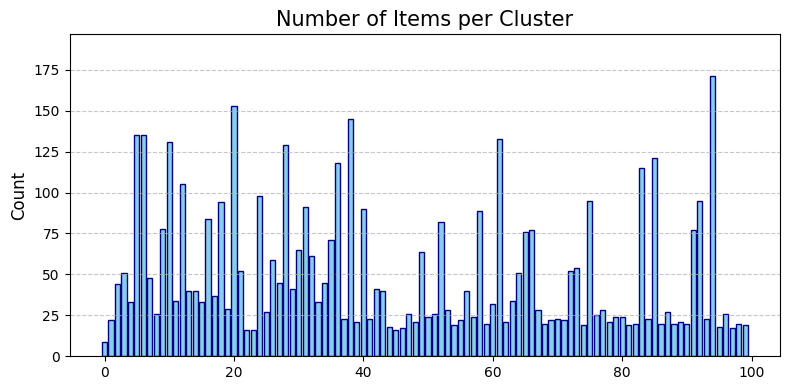

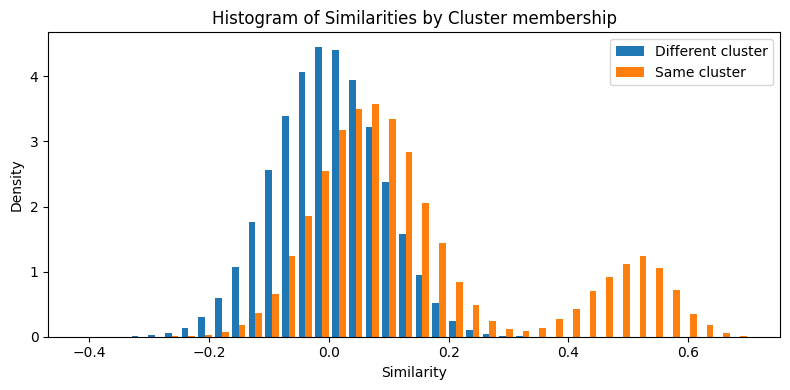

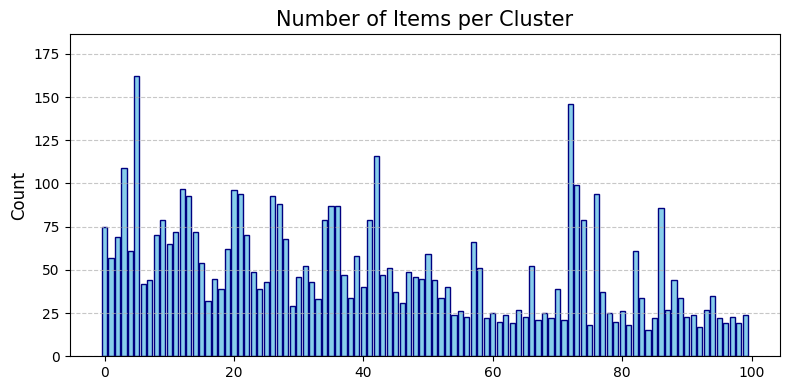

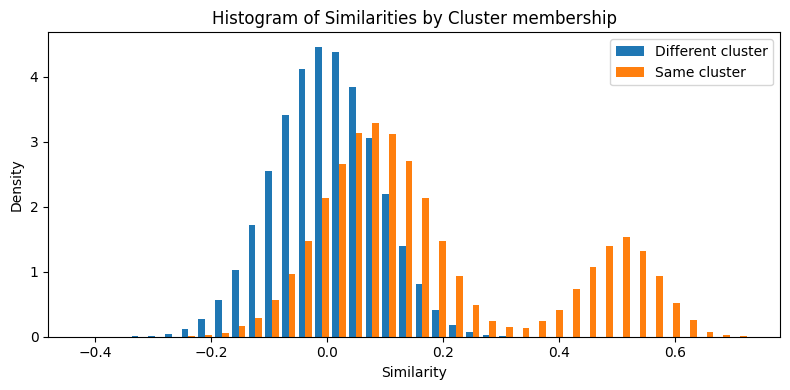

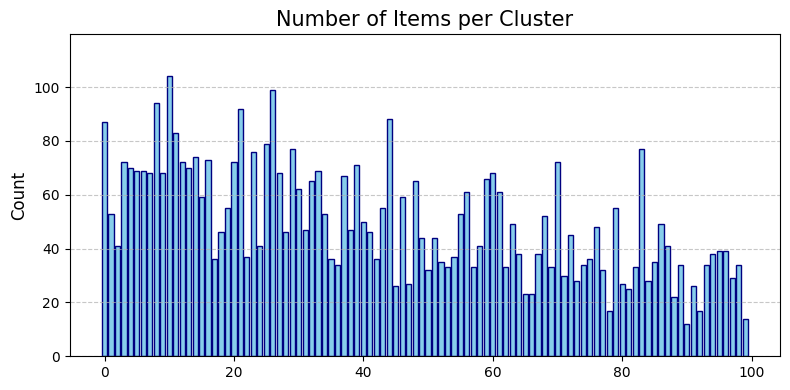

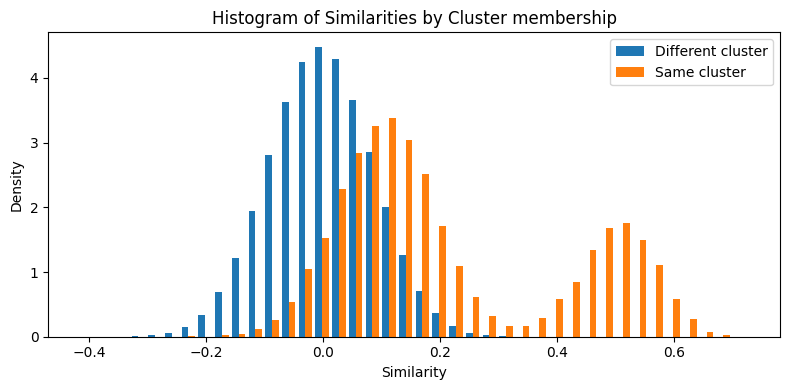

In [13]:
input_map = {
    "kmeans": KMeans(random_state=0, n_init="auto"),
    "agglom_base": AgglomerativeClustering(),
    "agglom_cosine": AgglomerativeClustering(metric="cosine", linkage="average"),
}
results = {}
for name, estimator in input_map.items():
    results[name] = estimate_and_evaluate(name, estimator, embs, n_clusters) 


In [14]:
[(k, v["scores"]) for k,v in results.items()]

[('kmeans',
  {'silhouette': 0.09824750318750639,
   'calinski_harabasz': 15.891140088294907,
   'davies_bouldin': 2.9492683384751484}),
 ('agglom_base',
  {'silhouette': 0.12071968232782754,
   'calinski_harabasz': 17.424385310995298,
   'davies_bouldin': 2.9474386007148343}),
 ('agglom_cosine',
  {'silhouette': 0.13501592141399632,
   'calinski_harabasz': 16.376413898183195,
   'davies_bouldin': 2.8073259478871524})]

### Summary
- agglomerative yields more equal-sized clusters
- little difference is closeness to own centroid
- the bivariate distributions are indicative of how well spatial information from original embeddings is preserved by clustering
- scoring metrics do not necessarily agree

To do next
- [x] look at bivariate distributions of cosine distances between units in same and different clusters
- [ ] ~~predict defining features of the network: municipality id? -> for clustering id, use the majority class or something?~~
- [ ] ~~spearman's rank correlation between the cluster centroid coordinates and the person coordinates~~
- [ ] make agglomerative more robust / use distance-specific stopping rule instead of hard-coded n clusters?